In [1]:
# Setup
from notebook_utils import resolve_paths_from_parent_directory

# auto reload notebook deps
%reload_ext autoreload
%autoreload
resolve_paths_from_parent_directory()

In [2]:
import torch
import torch.optim as optim
from utils import (
    split_img, 
    ToPILImage, 
    ToTensor
)
from tqdm import tqdm
from train import train
from model import SupUCA
from dataset import MNISTHalves
from torchvision import datasets
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

In [3]:
# set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# load training data
train_dataset = datasets.MNIST(root='../data/', train=True, download=True)
train_x = []
train_y = []

# split training images in half
for i in tqdm(range(train_dataset.data.shape[0])):
    img = ToPILImage(train_dataset.data[i])
    x, y = split_img(img)
    train_x.append(ToTensor(x))
    train_y.append(ToTensor(y))
train_x = torch.stack(train_x)
train_y = torch.stack(train_y)
train_label = train_dataset.targets

# center the training data by removing the mean
train_x_mean = train_x.mean()
train_y_mean = train_y.mean()
train_x = train_x - train_x_mean
train_y = train_y - train_y_mean

# load test data
test_dataset = datasets.MNIST(root='../data/', train=False, download=True)
test_x = []
test_y = []

# split test images in half
for i in tqdm(range(test_dataset.data.shape[0])):
    img = ToPILImage(test_dataset.data[i])
    x, y = split_img(img)
    test_x.append(ToTensor(x))
    test_y.append(ToTensor(y))
test_x = torch.stack(test_x)
test_y = torch.stack(test_y)
test_label = test_dataset.targets

# center the test data by removing the (training) mean
test_x = test_x - train_x_mean
test_y = test_y - train_y_mean

# build datasets / data loaders
batch_size = 32
train_data = MNISTHalves(train_x, train_y, train_label)
test_data = MNISTHalves(test_x, test_y, test_label)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

100%|██████████| 10000/10000 [00:06<00:00, 1450.14it/s]


In [13]:
# build model
model = SupUCA()
model.to(device)

# set optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5, amsgrad=True)

# set scheduler
step_size = 15
gamma = 0.5
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [14]:
model = train(model, optimizer, scheduler, train_loader, test_loader, device, epochs=26)

epoch: 0 | train: 0.085 | test: 0.016
epoch: 1 | train: 0.014 | test: 0.014
epoch: 2 | train: 0.013 | test: 0.014
epoch: 3 | train: 0.013 | test: 0.014
epoch: 4 | train: 0.013 | test: 0.013
epoch: 5 | train: 0.013 | test: 0.013
epoch: 6 | train: 0.012 | test: 0.013
epoch: 7 | train: 0.012 | test: 0.013
epoch: 8 | train: 0.012 | test: 0.013
epoch: 9 | train: 0.012 | test: 0.013
epoch: 10 | train: 0.012 | test: 0.013
epoch: 11 | train: 0.012 | test: 0.013
epoch: 12 | train: 0.012 | test: 0.013
epoch: 13 | train: 0.012 | test: 0.013
epoch: 14 | train: 0.012 | test: 0.013
epoch: 15 | train: 0.012 | test: 0.013
epoch: 16 | train: 0.012 | test: 0.013
epoch: 17 | train: 0.012 | test: 0.013
epoch: 18 | train: 0.012 | test: 0.013
epoch: 19 | train: 0.012 | test: 0.013
epoch: 20 | train: 0.012 | test: 0.013
epoch: 21 | train: 0.012 | test: 0.013
epoch: 22 | train: 0.012 | test: 0.013
epoch: 23 | train: 0.012 | test: 0.013
epoch: 24 | train: 0.012 | test: 0.013
epoch: 25 | train: 0.012 | test: 0.

In [8]:
img_idx = 8476
top_gt = test_data[img_idx][0]
bottom_gt = test_data[img_idx][1]

top


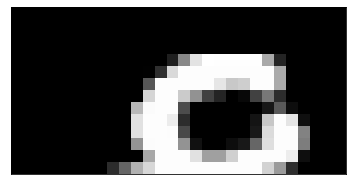

estimated bottom


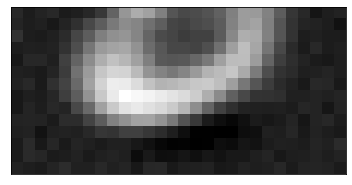

ground truth bottom


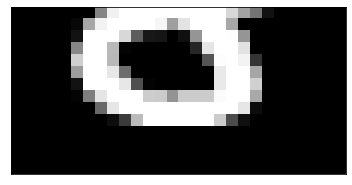

similarity: 0.67


In [19]:
print('top')
top_gt = top_gt.reshape(14, 28)
plt.imshow(top_gt, cmap='gray', interpolation='none')
plt.xticks([])
plt.yticks([])
plt.show()

print('estimated bottom')
top_rec = top_gt.reshape(1, 14 * 28)
top_rec = top_rec @ model.W_x.weight.t()
top_rec = top_rec @ model.V_y.weight.t()
top_rec = top_rec.reshape(14, 28).detach().numpy()
plt.imshow(top_rec, cmap='gray', interpolation='none')
plt.xticks([])
plt.yticks([])
plt.show()

print('ground truth bottom')
bottom_gt = bottom_gt.reshape(14, 28)
plt.imshow(bottom_gt, cmap='gray', interpolation='none')
plt.xticks([])
plt.yticks([])
plt.show()

input1 = bottom_gt.reshape(1, 14 * 28)
input2 = top_gt.reshape(1, 14 * 28)
input2 = input2 @ model.W_x.weight.t()
input2 = input2 @ model.V_y.weight.t()
input2 = input2.reshape(1, 14 * 28)
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
output = cos(input1, input2).item()
print(f'similarity: {output:.2f}')

In [18]:
# torch.save(model.state_dict(), '../saved_models/SupUCA.pickle')